# Developing a Collision Rate Estimation Model using 2016 AADT Volumes and 2016 Truck Speed Data, and 2016 Collision Data

In [1]:
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import r2_score
%matplotlib notebook

**The geopackage is pre processed. It is the result of joining MTO's 2016 AADT volumes and 2016 Truck Speed Data, and 2016 Collision Data**  
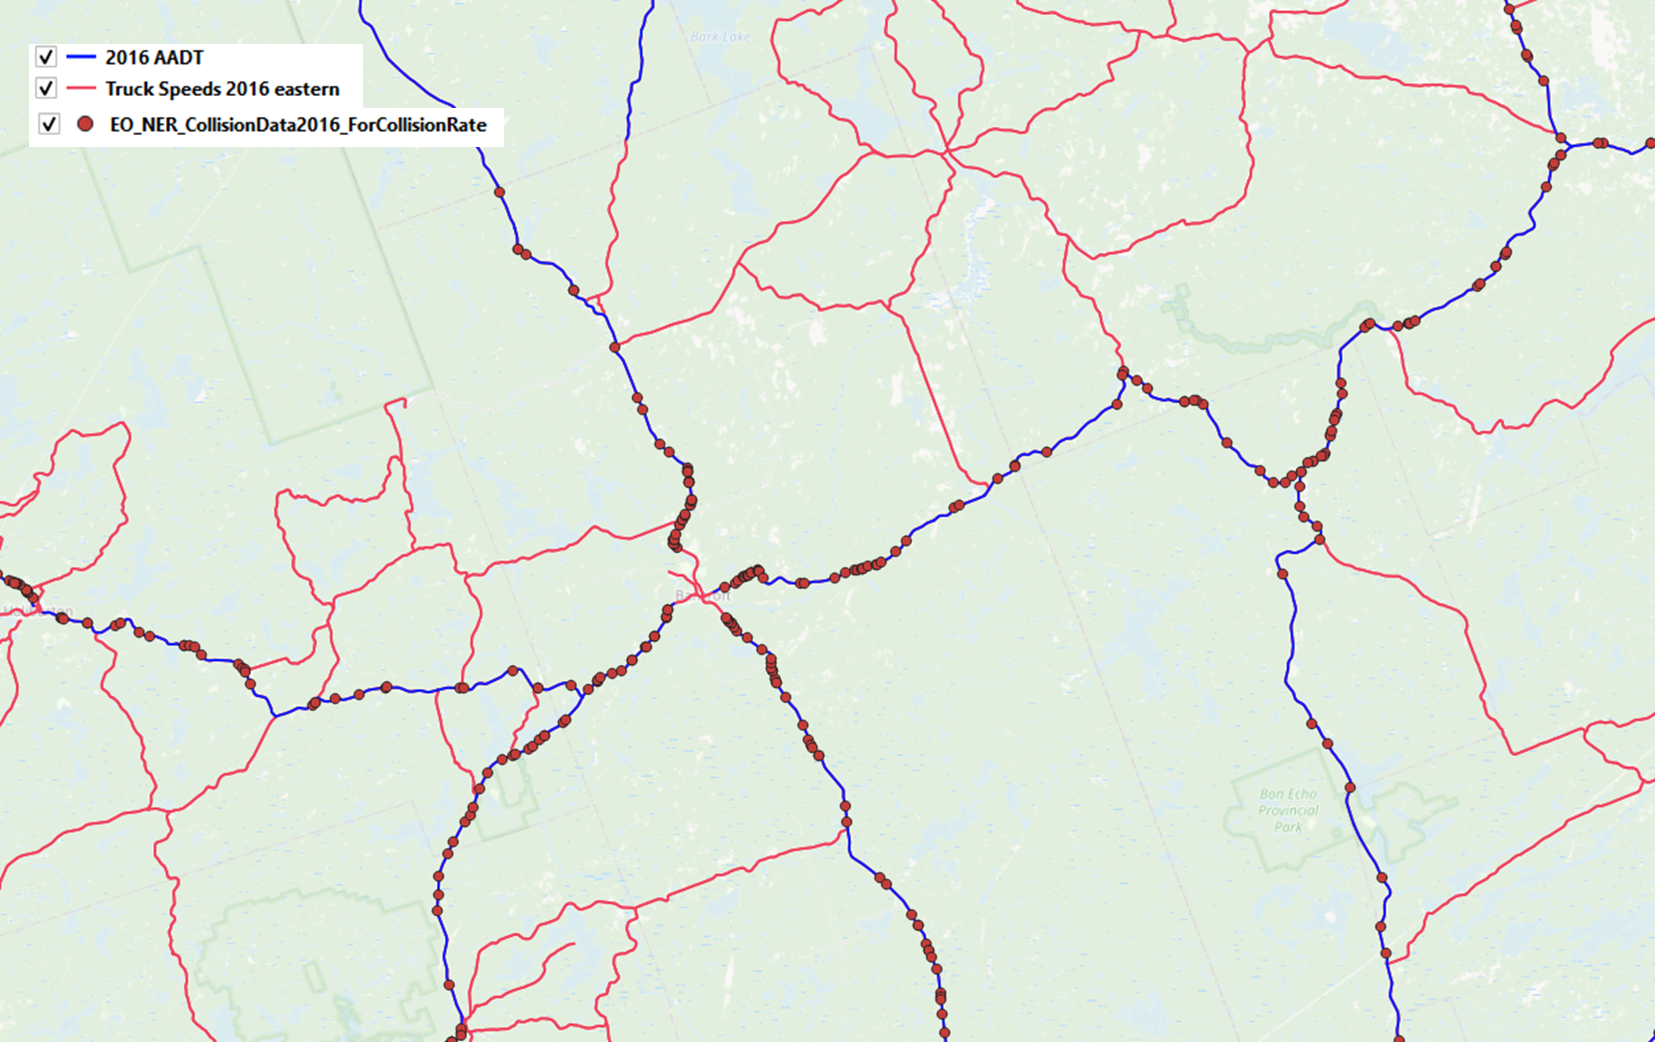

In [2]:
wdir = r"C:\Users\JACCHAN\HDR, Inc\MTO Eastern Ontario - Provincewide Plan - Documents\5.0_Proj_Dev\Data Analysis\Collision Data"
file_name_car = 'EO_NER_CollisionData2016_forCollisionRate.gpkg'
data_raw = gpd.read_file(wdir + '\\' + file_name_car)

# Functions used in Python Script

## Function for calculating collision rate
[Collision Rate Formula](https://safety.fhwa.dot.gov/local_rural/training/fhwasa1109/app_c.cfm)

In [3]:
def CollisionRate(collision, aadt, rdlen):
    if aadt*rdlen == 0:
        cr = 0
    else:
        cr = collision * 100000000 / (aadt*365*rdlen)
    return cr

## Function for checking unique features for each road segment from AADT geodata set
The road segments in the AADT geospatial dataset are aggregations of smaller road segments from the Truck Speed Data Set.  
By spatial joining these two datasets, it results in the aggregated road segments containing multiple features from the Truck Speed Data set.  
For example, road segment **X** may contain multiple 'LANES' or 'SPEED_LIMIT' features.  
  
Thus, I created two functions to take the most frequent occuring feature as the unique feature for road segment **X**

In [4]:
def CheckUniqueColumn(df, colname):
    List = df[colname].unique().tolist()
    if len(List) == 1:
        returnval = List[0]
        print('There is one unique ' + colname + ' value...The Value is ' + str(returnval))
    else:
        # return value of the most frequent element
        returnval = max(set(List), key = List.count)
        print('there are ' + str(len(List)) + ' ' + colname + ' value...The value carried forward is ' + str(returnval))
    return returnval

def CheckUnique(df):
    x1 = CheckUniqueColumn(df, 'FID_AADT')
    x2 = CheckUniqueColumn(df, 'LENGTH') # in kilometres
    x3 = CheckUniqueColumn(df, 'AADT16')
    x4 = CheckUniqueColumn(df, 'LANES')
    x5 = CheckUniqueColumn(df, 'SPDLIM') # in km/h
    x6 = CheckUniqueColumn(df, 'geog_div')
    x7 = len(df)
    #x8 = CheckUniqueColumn(df, 'FFS')
    return  x1, x2, x3, x4, x5, x6, x7, #x8

## Regression Functions
Creating functions for linear regression and plotting linear regression trend line.  
These linear regression models have forced intercept of 0 because 0 volumes would result in 0 collisions

In [5]:
def f0(x,m):
    return m*x

def LinRegr0(df, x_df_colname, y_df_colname):
    x = df[x_df_colname]
    y = df[y_df_colname]
    popt, pcov = curve_fit(f0,x,y)
    residuals = y - f0(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res/ss_tot)
    #for aesthetics
    regr_eq = 'y = ' + "{:.3e}".format(popt[0]) + '(x)'
    return r_squared, regr_eq, popt[0]

def PlotLinRegr0 (df, x_df_colname, y_df_colname, cof, xtitle, ytitle, title, colorindex):
    fig = plt.figure()
    ax = sns.scatterplot(data=df, x = x_df_colname, y = y_df_colname,
                color = sns.color_palette()[colorindex-1])
    x2 = [int(df[x_df_colname].min()), int(df[x_df_colname].max())]
    y2 = list(np.array(x2)*cof)
    sns.lineplot(x=x2, y=y2, color =sns.color_palette()[colorindex-1])

    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(title) #+ '\n' + str(j) + 'LANES')
    plt.text(0.05,0.95, regr_eq, 
             ha = 'left',
             va = 'center', 
             transform = plt.gca().transAxes)
    plt.text(0.05,0.9, 'r_squared = ' + "{:.3f}".format(r_squared),
             ha = 'left',
             va = 'center',
             transform = plt.gca().transAxes)
    plt.xlim(left = 0)
    plt.ylim(bottom = 0)
    return fig

Creating unique lists of features from geospatial data.  

Then, creating a dataframe to store data.

In [6]:
fid_aadt = data_raw['FID_AADT'].unique().tolist()
speedlim = data_raw['SPDLIM'].unique().tolist()
lanes = data_raw['LANES'].unique().tolist()
df2 = pd.DataFrame(columns = ['FID_AADT',
                              'LENGTH',
                              'AADT16', 
                              'LANES', 
                              'SPDLIM',
                              'SPDLIM_cat',
                              'geog_div',
                              'numcollision',
                              'collision_rate', 
                              'VKT'])

In [7]:
for i in fid_aadt:
    print('\n' + 'Analyzing FID_AADT = ' + str(i))
    fid_aadt, length, aadtvol, numlanes, spdlim, subregion, numcollision = CheckUnique(data_raw[data_raw['FID_AADT'] == i])   
    collisionrate = CollisionRate(numcollision,aadtvol, length)   
    row = {'FID_AADT': fid_aadt,
           'LENGTH': length,
           'AADT16': aadtvol, 
           'LANES': numlanes,
           'SPDLIM':spdlim,
           'SPDLIM_cat': spdlim,
           'geog_div': subregion,
           'numcollision': numcollision,
           'collision_rate':collisionrate,
           'VKT': length*aadtvol
           }
        
    # somehow these columns get converted to objects. reconvert to float64
    df2['FID_AADT'] = pd.to_numeric(df2['FID_AADT'])
    df2['AADT16'] = pd.to_numeric(df2['AADT16'])
    df2['LANES'] = pd.to_numeric(df2['LANES'])
    df2['geog_div'] = pd.to_numeric(df2['geog_div'])
    df2['numcollision'] = pd.to_numeric(df2['numcollision'])
    
    #total collision rate
    print('Collision Rate for FID_AADT = ' + str(i) + ' is ' + str(collisionrate))
    
    #for categorizing
    df2['SPDLIM_cat'] = df2['SPDLIM_cat'].replace([i for i in speedlim if i == 80], '80')
    df2['SPDLIM_cat'] = df2['SPDLIM_cat'].replace([i for i in speedlim if i > 80], '90-100')


Analyzing FID_AADT = 880
There is one unique FID_AADT value...The Value is 880
There is one unique LENGTH value...The Value is 1.01
There is one unique AADT16 value...The Value is 5400
There is one unique LANES value...The Value is 2
There is one unique SPDLIM value...The Value is 80.0
There is one unique geog_div value...The Value is 3
Collision Rate for FID_AADT = 880 is 100.46666767133334

Analyzing FID_AADT = 570
There is one unique FID_AADT value...The Value is 570
There is one unique LENGTH value...The Value is 2.55
There is one unique AADT16 value...The Value is 17600
There is one unique LANES value...The Value is 2
There is one unique SPDLIM value...The Value is 100.0
There is one unique geog_div value...The Value is 1
Collision Rate for FID_AADT = 570 is 36.62735330745001

Analyzing FID_AADT = 455
There is one unique FID_AADT value...The Value is 455
There is one unique LENGTH value...The Value is 7.56
There is one unique AADT16 value...The Value is 19100
There is one unique 

There is one unique FID_AADT value...The Value is 751
There is one unique LENGTH value...The Value is 4.94
There is one unique AADT16 value...The Value is 1600
There is one unique LANES value...The Value is 2
There is one unique SPDLIM value...The Value is 80.0
There is one unique geog_div value...The Value is 5
Collision Rate for FID_AADT = 751 is 69.32505130053796

Analyzing FID_AADT = 750
There is one unique FID_AADT value...The Value is 750
There is one unique LENGTH value...The Value is 9.47
There is one unique AADT16 value...The Value is 1350
There is one unique LANES value...The Value is 2
There is one unique SPDLIM value...The Value is 80.0
there are 2 geog_div value...The value carried forward is 0
Collision Rate for FID_AADT = 750 is 107.1503002619289

Analyzing FID_AADT = 728
There is one unique FID_AADT value...The Value is 728
There is one unique LENGTH value...The Value is 4.64
There is one unique AADT16 value...The Value is 2100
There is one unique LANES value...The Valu

There is one unique FID_AADT value...The Value is 20
There is one unique LENGTH value...The Value is 6.73
There is one unique AADT16 value...The Value is 18500
There is one unique LANES value...The Value is 2
There is one unique SPDLIM value...The Value is 100.0
There is one unique geog_div value...The Value is 1
Collision Rate for FID_AADT = 20 is 39.608906062528156

Analyzing FID_AADT = 1534
There is one unique FID_AADT value...The Value is 1534
There is one unique LENGTH value...The Value is 10.01
There is one unique AADT16 value...The Value is 17400
There is one unique LANES value...The Value is 2
There is one unique SPDLIM value...The Value is 100.0
There is one unique geog_div value...The Value is 1
Collision Rate for FID_AADT = 1534 is 31.459644119067832

Analyzing FID_AADT = 601
There is one unique FID_AADT value...The Value is 601
There is one unique LENGTH value...The Value is 3.08
There is one unique AADT16 value...The Value is 18800
There is one unique LANES value...The Val

# Plotting Regression Analyses

In [11]:
for i, j in enumerate(df2['SPDLIM_cat'].unique().tolist()):
    df3 = df2[df2['SPDLIM_cat'] == j]
    if j == '90-100' :
        q1 = np.percentile(df3['numcollision'], 25, interpolation = 'midpoint')
        q3 = np.percentile(df3['numcollision'], 75, interpolation = 'midpoint')
        iqr = q3-q1
        upper = q3 + 1.5*iqr
        lower = q1 - 1.5*iqr
        df4 = df3[(df3['numcollision'] <= upper) & (df3['numcollision'] >= lower)]
    else:
        df4 = df3
    r_squared, regr_eq, cof1 = LinRegr0(df4, 'VKT','numcollision')
    
    xlabel = "Vehicle Kilometres Travelled (VKT) "
    ylabel = "Number of Collisions"
    titlelabel = ('Regression of Collision Frequency and VKT -\n' 
                  + j 
                  + ' km/h')
    fig = PlotLinRegr0(df4,'VKT','numcollision',cof1, xlabel,ylabel,titlelabel,i)

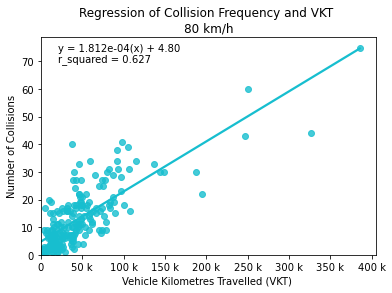  

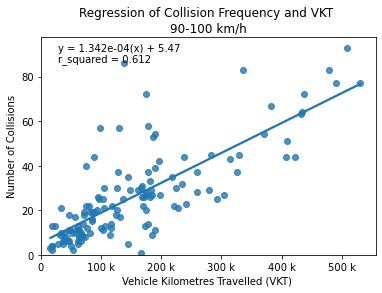